### __Introduction__
#### India is one of the major economies of world, with a large consumer population and a wide variety of products and services in market. This makes up for a hugh amount of daily financial transactions. While India is moving towards digital cashless transaction still a very large percentage of transactions are with cash. This hugh cash demand makes ATM a key service/product for a banks customer, and right location to set up an ATM can be a good strategy for any bank.

### __Business problem__
#### For a bank to increase it's reach to customer in terms of providing services relies on ATM as they are the easiest and most convienient way to acquire cash. Its important for a bank to find best location to reach large customers and this will be the focus here. We will be tackling one of the cities in India and find out best location for ATM.

#### Here for this project I have choosen __Ahmedabad__ city located in Gujarat, India.

In [2]:
#importing libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### __Data gathering and processing__

#### To get required data following steps are taken

#### 1. We performed web scraping using BeautifulSoup to get neighborhoods from https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Ahmedabad

#### 2. Acquiring coordinates data using geocoder.arcgis and then adding the coordinates to main dataframe

#### 3. Venues data will be obtained from Foursquare through an API.


#### __Scraping table from the link__

In [3]:
data = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Ahmedabad').text
soup = BeautifulSoup(data, 'html.parser')

In [4]:
neighborhoodList = []
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [5]:
df = pd.DataFrame({"Neighborhood": neighborhoodList})
df.head()

,Neighborhood
0,Agol
1,Ahmedabad Cantonment
2,Alam Roza
3,Ambawadi
4,Amraiwadi


#### Acquiring coordinates data using geocoder.arcgis and then adding the coordinates to main dataframe

In [6]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Ahmedabad, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [7]:
coords = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]


In [8]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])


In [9]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [10]:
print(df.shape)
df.head()

(81, 3)


,Neighborhood,Latitude,Longitude
0,Agol,23.02776,72.60027
1,Ahmedabad Cantonment,23.02776,72.60027
2,Alam Roza,23.00212,72.54979
3,Ambawadi,23.01885,72.55441
4,Amraiwadi,23.00735,72.62268


In [11]:
address = 'Ahmedabad, India'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ahmedabad are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ahmedabad are 23.0216238, 72.5797068.


### Visualizing Ahmedabad map

In [18]:
# create map of Ahmedabad using latitude and longitude values
map_ahmedabad = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ahmedabad)  
    
map_ahmedabad

#### Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [13]:
# Define Foursquare Credentials and Version
LIMIT = 100

CLIENT_ID = '4TWLVWSSVJKC4DNDVBGEV0HKUSB1JUVWU3XXTMRHKT1NW5BG' # your Foursquare ID
CLIENT_SECRET = 'KFNHVLVHBWB5DRJVBXL1OZYOWAAUOA0Z3JKUVE5GJPNDUMIA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4TWLVWSSVJKC4DNDVBGEV0HKUSB1JUVWU3XXTMRHKT1NW5BG
CLIENT_SECRET:KFNHVLVHBWB5DRJVBXL1OZYOWAAUOA0Z3JKUVE5GJPNDUMIA


### Fuction to explore neighborhoods in Ahmedabad

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called Ahmedabad_venues

In [16]:
ahmedabad_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                  )

Agol
Ahmedabad Cantonment
Alam Roza
Ambawadi
Amraiwadi
Anand Nagar (Ahmedabad)
Asarwa
Asarwa Chakla
Badarkha
Bahiyal
Bapunagar
Bareja (area)
Behrampura
Bhadiad
Bhairavnath Road
Bhojva
Bopal
Calico Mills (area)
Chaloda
Chandkheda
Chandlodiya
Dabhoda
Dariapur (Ahmedabad)
Detroj
Ellis bridge (area)
Ghatlodiya
Ghodasar
Girdharnagar
Gita Mandir Road
Godhavi
Gomtipur
Gota, Gujarat
Isanpur
Jamalpur, Gujarat
Jawahar Chowk
Jholapur
Jivrajpark
Jodhpur, Gujarat
Juhapura
Kabirchowk
Kalupur
Kalyanpura (Ahmedabad)
Khadia, Ahmedabad
Kharna
Khodiyarnagar
Khokhra
Lambha
Makarba
Maninagar
Memnagar
Mithakali
Motera
Naranpura
Naroda
Nava Vadaj
Navarangpura
Navjivan (Neighbourhood)
Odhav
Paldi
Polarpur
Rajpur Gomtipur
Ramol
Ranip
Sabarmati (area)
Saraspur
Sardarnagar
Sarkhej
Shahibaug
Shahpur, Gujarat
Shardanagar
Shastrinagar
Subhash Bridge
Sukhrampura
Thakkar Bapanagar
Thaltej
Ujedia
Usmanpura
Vastral
Vastrapur
Vejalpur
Virochannagar


In [24]:
# checkout the new dataframe
ahmedabad_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agol,23.02776,72.60027,Moti Mahal,23.029120,72.599724,Indian Restaurant
1,Agol,23.02776,72.60027,K.C,23.027829,72.600110,Men's Store
2,Agol,23.02776,72.60027,Maskati Market,23.029105,72.599616,Clothing Store
3,Agol,23.02776,72.60027,Hotel Ritz Inn Ahmedabad,23.029712,72.599267,Motel
4,Ahmedabad Cantonment,23.02776,72.60027,Moti Mahal,23.029120,72.599724,Indian Restaurant


In [25]:
#dimensions of new dataframe
ahmedabad_venues.shape


(240, 7)

In [26]:
# no. of venues were returned for each neighborhood
ahmedabad_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agol,4,4,4,4,4,4
Ahmedabad Cantonment,4,4,4,4,4,4
Alam Roza,3,3,3,3,3,3
Ambawadi,10,10,10,10,10,10
Amraiwadi,2,2,2,2,2,2
Anand Nagar (Ahmedabad),6,6,6,6,6,6
Asarwa,2,2,2,2,2,2
Asarwa Chakla,2,2,2,2,2,2
Bahiyal,4,4,4,4,4,4


In [27]:
#unique categories from all the returned venues
print('There are {} uniques categories.'.format(len(ahmedabad_venues['Venue Category'].unique())))


There are 67 uniques categories.


#### Hot encode to covert categorical values to numerical, this will help analyze each neighborhood, and create new dataframe

In [28]:
# one hot encoding
ahmedabad_onehot = pd.get_dummies(ahmedabad_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ahmedabad_onehot['Neighborhood'] = ahmedabad_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ahmedabad_onehot.columns[-1]] + list(ahmedabad_onehot.columns[:-1])
ahmedabad_onehot = ahmedabad_onehot[fixed_columns]

ahmedabad_onehot.head()

,Neighborhood,ATM,Accessories Store,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bed & Breakfast,Bistro,Bookstore,Boutique,Bus Station,Business Service,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop,Farm,Fast Food Restaurant,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gift Shop,Gourmet Shop,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Market,Men's Store,Metro Station,Mexican Restaurant,Motel,Movie Theater,Moving Target,Multiplex,Park,Performing Arts Venue,Pizza Place,Platform,Restaurant,River,Sandwich Place,Shopping Mall,Snack Place,Tea Room,Tennis Stadium,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant
0,Agol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ahmedabad Cantonment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### __Methodology__

#### The methodology in this project consists of two parts:

#### __Exploratory Data Analysis__: Visualise and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.

#### __Modelling__: To find similar neighborhoods we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. To find out best K we will be finding out distortion/inertia and also if needed Silhouette score. K-mean will group similar neighbourhoods into clusters, these clusters should have a a lot of common venues and this will help us understand which clusters and in turn which neighbourhoods are best.

In [29]:
# Examine the new data frame
ahmedabad_onehot.shape

(240, 68)

#### Grouping rows by neighborhood and on basis of the mean of the frequency of each category

In [30]:
ahmedabad_grouped = ahmedabad_onehot.groupby('Neighborhood').mean().reset_index()
ahmedabad_grouped

,Neighborhood,ATM,Accessories Store,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bed & Breakfast,Bistro,Bookstore,Boutique,Bus Station,Business Service,Café,Chaat Place,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop,Farm,Fast Food Restaurant,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gift Shop,Gourmet Shop,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Market,Men's Store,Metro Station,Mexican Restaurant,Motel,Movie Theater,Moving Target,Multiplex,Park,Performing Arts Venue,Pizza Place,Platform,Restaurant,River,Sandwich Place,Shopping Mall,Snack Place,Tea Room,Tennis Stadium,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant
0,Agol,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.00,0.25,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000
1,Ahmedabad Cantonment,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.00,0.25,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000
2,Alam Roza,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.333333,0.0,0.00,0.000000,0.0,0.000000,0.00,0.333333,0.333333,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000
3,Ambawadi,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.300000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.1,0.00,0.000000,0.0,0.000000,0.1,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,0.00,0.000000,0.0,0.000000,0.00,0.000000
4,Amraiwadi,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.5,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000
5,Anand Nagar (Ahmedabad),0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.166667,0.0,0.000000,0.00,0.000000
6,Asarwa,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00

In [31]:
# confirm the new size
ahmedabad_grouped.shape

(65, 68)

#### Each neighborhood with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in ahmedabad_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ahmedabad_grouped[ahmedabad_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agol----
               venue  freq
0     Clothing Store  0.25
1              Motel  0.25
2        Men's Store  0.25
3  Indian Restaurant  0.25
4          Juice Bar  0.00


----Ahmedabad Cantonment----
               venue  freq
0     Clothing Store  0.25
1              Motel  0.25
2        Men's Store  0.25
3  Indian Restaurant  0.25
4          Juice Bar  0.00


----Alam Roza----
            venue  freq
0          Garden  0.33
1           Hotel  0.33
2  Ice Cream Shop  0.33
3             ATM  0.00
4       Juice Bar  0.00


----Ambawadi----
                  venue  freq
0  Fast Food Restaurant   0.3
1         Shopping Mall   0.2
2           Pizza Place   0.2
3                  Park   0.1
4                  Café   0.1


----Amraiwadi----
               venue  freq
0                ATM   0.5
1  Health Food Store   0.5
2      Movie Theater   0.0
3      Historic Site   0.0
4     History Museum   0.0


----Anand Nagar (Ahmedabad)----
                  venue  freq
0  Fast Food Restaurant

#### Sorting the venues in descending order

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating new dataframe to show top 10 venues for each neighborhood

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ahmedabad_grouped['Neighborhood']

for ind in np.arange(ahmedabad_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ahmedabad_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agol,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
1,Ahmedabad Cantonment,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
2,Alam Roza,Garden,Ice Cream Shop,Hotel,Fried Chicken Joint,Food Truck,Food Court,Fast Food Restaurant,Farm,Clothing Store,Fruit & Vegetable Store
3,Ambawadi,Fast Food Restaurant,Pizza Place,Shopping Mall,Café,Mexican Restaurant,Park,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop
4,Amraiwadi,ATM,Health Food Store,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm


#### To determine best no. of clusters on basis of determining the inertia within cluster

#### We will plot for Distortion vs No. of clusters and look for a forming of an elbow this will be the point where change in cluster doesn't afftect much change in distortion

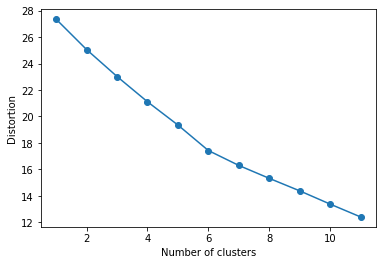

In [35]:
import matplotlib.pyplot as plt
# calculate distortion for a range of number of cluster
ahmedabad_grouped_clustering = ahmedabad_grouped.drop('Neighborhood', 1)
distortions = []
for i in range(1, 12):
    km = KMeans(n_clusters=i, n_init = 50, max_iter=300,tol=1e-100, random_state=0)
    km.fit(ahmedabad_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 12), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### Plot of Distortion vs Number of clusters is not quite clear in providing the best number, we will now look for silhouette score to help us determine best number of cluster

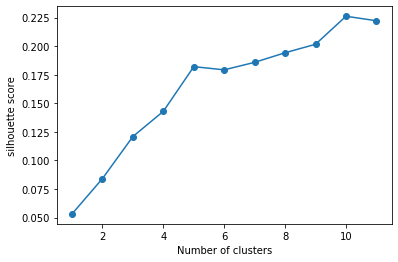

In [36]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 12

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for i in range(2, kmax+1):
  kmeans = KMeans(n_clusters=i, n_init = 50, max_iter=300,tol=1e-100, random_state=0).fit(ahmedabad_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(ahmedabad_grouped_clustering, labels, metric = 'euclidean'))

# plot
plt.plot(range(1, 12), sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

#### Silhouette score tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1. Score should be closer to 1 than -1

#### Silhouette score shows that best number of clusters is 10

#### Run k-means to cluster the neighborhood into 10 clusters.



In [37]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init = 50, max_iter=300,tol=1e-100, random_state=0).fit(ahmedabad_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 7, 7, 3, 7, 7, 7, 1, 0], dtype=int32)

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ahmedabad_merged = df

# merge ahmedabad_grouped with ahmedabad_data to add latitude/longitude for each neighborhood
ahmedabad_merged = ahmedabad_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how = 'right')

ahmedabad_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agol,23.02776,72.60027,1,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
1,Ahmedabad Cantonment,23.02776,72.60027,1,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
2,Alam Roza,23.00212,72.54979,7,Garden,Ice Cream Shop,Hotel,Fried Chicken Joint,Food Truck,Food Court,Fast Food Restaurant,Farm,Clothing Store,Fruit & Vegetable Store
3,Ambawadi,23.01885,72.55441,7,Fast Food Restaurant,Pizza Place,Shopping Mall,Café,Mexican Restaurant,Park,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop
4,Amraiwadi,23.00735,72.62268,3,ATM,Health Food Store,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm


In [39]:
ahmedabad_merged.groupby('Cluster Labels').count()


,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
0,13,13,13,13,13,13,13,13,13,13,13,13,13
1,8,8,8,8,8,8,8,8,8,8,8,8,8
2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,7,7,7,7,7,7,7,7,7,7,7,7,7
4,3,3,3,3,3,3,3,3,3,3,3,3,3
5,2,2,2,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1,1,1,1
7,27,27,27,27,27,27,27,27,27,27,27,27,27
8,1,1,1,1,1,1,1,1,1,1,1,1,1


### Visualizing the clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ahmedabad_merged['Latitude'], ahmedabad_merged['Longitude'], ahmedabad_merged['Neighborhood'], ahmedabad_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### __Cluster 1__

In [41]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 0, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bapunagar,ATM,Arts & Crafts Store,Pizza Place,Indian Restaurant,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant
19,Chandkheda,ATM,Indian Restaurant,Fast Food Restaurant,Shopping Mall,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop
30,Gomtipur,Indian Restaurant,Moving Target,Vegetarian / Vegan Restaurant,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Chinese Restaurant
32,Isanpur,ATM,Indian Restaurant,Café,Fast Food Restaurant,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop
49,Memnagar,Indian Restaurant,Fast Food Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner
53,Naroda,Restaurant,Multiplex,Indian Restaurant,Pizza Place,Department Store,Clothing Store,Coffee Shop,Cosmetics Shop,Dance Studio,Vegetarian / Vegan Restaurant
56,Navjivan (Neighbourhood),Indian Restaurant,Coffee Shop,Arcade,Café,Hotel,Bistro,Vegetarian / Vegan Restaurant,Dance Studio,Department Store,Dessert Shop
58,Paldi,Tea Room,Indian Restaurant,Theater,Food Truck,Vegetarian / Vegan Restaurant,Dessert Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store
60,Rajpur Gomtipur,Indian Restaurant,Moving Target,Vegetarian / Vegan Restaurant,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Chinese Restaurant
62,Ranip,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop,Garden


#### __Cluster 2__

In [42]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 1, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agol,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
1,Ahmedabad Cantonment,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
9,Bahiyal,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
21,Dabhoda,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
35,Jholapur,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
43,Kharna,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
59,Polarpur,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop
75,Ujedia,Motel,Indian Restaurant,Men's Store,Clothing Store,Food Court,Fast Food Restaurant,Farm,Donut Shop,Chinese Restaurant,Dessert Shop


#### __Cluster 3__

In [43]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 2, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Bareja (area),Bus Station,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop,Chinese Restaurant
54,Nava Vadaj,Bus Station,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop,Chinese Restaurant


#### __Cluster 4__

In [44]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 3, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Amraiwadi,ATM,Health Food Store,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm
12,Behrampura,ATM,Business Service,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop,Chinese Restaurant
22,Dariapur (Ahmedabad),ATM,Pizza Place,Dessert Shop,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Donut Shop,Chinese Restaurant
26,Ghodasar,ATM,Business Service,Food Truck,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop
29,Godhavi,ATM,Chinese Restaurant,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Fast Food Restaurant,Farm,Donut Shop,Diner
44,Khodiyarnagar,ATM,Health & Beauty Service,Shopping Mall,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Farm
66,Sarkhej,ATM,Snack Place,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm


#### __Cluster 5__

In [45]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 4, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Ghatlodiya,Ice Cream Shop,Department Store,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Dessert Shop,Diner,Vegetarian / Vegan Restaurant,Garden
65,Sardarnagar,Ice Cream Shop,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Vegetarian / Vegan Restaurant,Garden
73,Thakkar Bapanagar,Ice Cream Shop,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Vegetarian / Vegan Restaurant,Garden


#### __Cluster 6__

In [46]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 5, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Ellis bridge (area),River,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Vegetarian / Vegan Restaurant,Chinese Restaurant
39,Kabirchowk,River,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Vegetarian / Vegan Restaurant,Chinese Restaurant


#### __Cluster 7__

In [47]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 6, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Girdharnagar,History Museum,Vegetarian / Vegan Restaurant,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm


#### __Cluster 8__

In [48]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 7, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alam Roza,Garden,Ice Cream Shop,Hotel,Fried Chicken Joint,Food Truck,Food Court,Fast Food Restaurant,Farm,Clothing Store,Fruit & Vegetable Store
3,Ambawadi,Fast Food Restaurant,Pizza Place,Shopping Mall,Café,Mexican Restaurant,Park,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop
5,Anand Nagar (Ahmedabad),Fast Food Restaurant,Chaat Place,Indian Restaurant,Café,Tea Room,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
6,Asarwa,Tennis Stadium,Chinese Restaurant,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Farm
7,Asarwa Chakla,Tea Room,Historic Site,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Farm
14,Bhairavnath Road,Restaurant,Coffee Shop,Fast Food Restaurant,Sandwich Place,Diner,Clothing Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
16,Bopal,Fruit & Vegetable Store,Café,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Donut Shop
28,Gita Mandir Road,Hotel,Platform,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop
31,"Gota, Gujarat",Gift Shop,Chinese Restaurant,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Fast Food Restaurant,Farm,Donut Shop,Diner
34,Jawahar Chowk,Multiplex,Sandwich Place,River,Vegetarian / Vegan Restaurant,Dessert Shop,Clothing Store,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store


#### __Cluster 9__

In [49]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 8, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Ramol,Asian Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Farm


#### __Cluster 10__

In [50]:
ahmedabad_merged.loc[ahmedabad_merged['Cluster Labels'] == 9, ahmedabad_merged.columns[[0] + list(range(4, ahmedabad_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Juhapura,Metro Station,Vegetarian / Vegan Restaurant,Diner,Coffee Shop,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Donut Shop,Garden


 ### Observation

#### Cluster 1 is very large with restuarant, coffee shops and other outside eateries as most common venues, it also shows 3 neighbourhood with ATM as most common venue
#### Cluster 2 is 3rd biggest cluster with neighbourhoods with completely similar common venues
#### Cluster 3 consist of 2 neighbourhood with Bus Station as most common venue  
#### Cluster 4  consist of neighbourhood with ATM being most common venue
#### Cluster 5 consist of 3 neighbourhood with completely similar common venues
#### Cluster 6 consist of 2 neighbourhood with completely similar common venues
#### Cluster 7, 9, 10 consist of only 1 neighbourhood each
#### Cluster 8 is largest cluster with 27 neighbourhoods
